# **MANDACARU.DEV - TIME 09 - CLASSIFICADOR DE SENTIMENTOS DE NOTÍCIAS - PERSPECTIVA ANALÍTICA**

---
Akyla Aquino, Cauã Braga, Evandro Martins, Geovana Rodrigues, Yann Lucca.

---



In [ ]:
#IMPORTAÇÃO DAS BIBLIOTECAS NECESSÁRIAS:
import numpy as np
import pandas as pd
import nltk
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.corpus import stopwords
nltk.download('stopwords')
import re
from sklearn.utils import resample
from wordcloud import WordCloud
import matplotlib.pyplot as plt
!pip install spacy
!python -m spacy download en_core_web_sm
import spacy
from collections import Counter
from nltk import ne_chunk, pos_tag
from nltk.tree import Tree
nltk.download('maxent_ne_chunker')
nltk.download('averaged_perceptron_tagger')
nltk.download('words')
from sklearn.feature_extraction.text import CountVectorizer
import altair as alt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


2023-12-06 11:14:18.308678: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-06 11:14:18.308745: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-06 11:14:18.308787: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-06 11:14:19.586679: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 57.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


# **1. ANÁLISE DE SENTIMENTOS**

---
Este projeto utiliza técnicas de processamento de linguagem natural (PLN) para classificar os sentimentos de trechos de notícias.


# **2. DATASET**


---

A base de dados utilizada foi disponibilizada pela organização do Mandacaru.Dev e contém colunas referentes às sentenças a serem analisadas (coluna Sentence) e os sentimentos associados a essas sentenças (coluna Sentiment), sendo classificados em positivos, negativos ou neutros. Segue uma amostra de 10 elementos do DataSet:

In [ ]:
#CARREGAMENTO DO DATASET EM FORMA DE DATAFRAME E EXIBIÇÃO OS 10 PRIMEIROS ELEMENTOS:
dataset = pd.read_csv("/content/data.csv")
dataset.head(10)

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral
5,$SPY wouldn't be surprised to see a green close,positive
6,Shell's $70 Billion BG Deal Meets Shareholder ...,negative
7,SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANG...,negative
8,Kone 's net sales rose by some 14 % year-on-ye...,positive
9,The Stockmann department store will have a tot...,neutral


## **3. PRÉ-PROCESSAMENTO**

---
As técnicas de remoção de caracteres especiais, remoção de StopWords, Lematização, Normalização, remoção de links e Tokenização foram utilizadas para o processamento textual da coluna "Sentence". O pré-processamento foi realizando utilizando a GPU do Google Colab contendo todas as 5842 linhas do DataSet. O algoritmo de pré-processamento está documentado a seguir:



In [ ]:
#EXTRAÇÃO DO TIPO DE DADOS DO DATASET:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


In [ ]:
#SALVANDO A COLUNA "SENTENCE" EM UMA LISTA:
noticia = dataset.Sentence

#SALVANDO A COLUNA "SENTIMENT" EM UMA LISTA:
sentimento = dataset.Sentiment

In [ ]:
#REMOÇÃO DE LINHAS REPETIDAS DO DATASET:
boole = noticia.duplicated()

noticia_nao_repetida = []
sentimento_nao_repetido = []

for i in range(len(noticia)):
  if not boole[i]:
    noticia_nao_repetida.append(noticia[i])
    sentimento_nao_repetido.append(sentimento[i])

In [ ]:
#REMOÇÃO DE LINKS DA COLUNA "SENTENCE" DO DATASET:
def remove_links(sentence):
    link_padrao = re.compile(r'https?://\S+|www\.\S+')
    sentenca_sem_links = re.sub(link_padrao, '', sentence)

    return sentenca_sem_links

# Exemplo de uso
noticia_sem_links = [remove_links(sentenca) for sentenca in noticia_nao_repetida]

In [ ]:
#TOKENIZAÇÃO DA COLUNA "SENTENCE":
noticia_tokens = [nltk.word_tokenize(noticia) for noticia in noticia_sem_links]

#NORMALIZAÇÃO DA COLUNA "SENTENCE":
noticia_normalizado = [None]*len(noticia_tokens)
for i in range (len(noticia_tokens)):
  noticia_normalizado[i] = [word.lower() for word in noticia_tokens[i] if word.isalnum()]

#NORMALIZAÇÃO DA COLUNA "SENTIMENT":
sentimento_normalizado = [word.lower() for word in sentimento_nao_repetido if word.isalpha]

In [ ]:
#REMOÇÃO DE STOPWORDS DA COLUNA "SENTENCE":
noticia_filtrado = [None]*len(noticia_normalizado)
stop_words = set(stopwords.words('english'))
for i in range (len(noticia_normalizado)):
  noticia_filtrado[i] = [token.lower() for token in noticia_normalizado[i] if not token in stop_words]

In [ ]:
#LEMATIZAÇÃO TEXTUAL DA COLUNA "SENTENCE":
lematizador = WordNetLemmatizer()
noticia_lematizado = [None]*len(noticia_filtrado)
for i in range (len(noticia_tokens)):
  noticia_lematizado[i] = [lematizador.lemmatize(token) for token in noticia_filtrado[i]]

In [ ]:
#ARMAZENAMENTO DOS DADOS TRATADOS EM UM NOVO DATASET:
novo_dataset = pd.DataFrame({'Sentence':noticia_lematizado, 'Sentiment':sentimento_normalizado})

#AMOSTRA DOS DADOS TRATADOS:
novo_dataset.head(10)

,Sentence,Sentiment
0,"[geosolutions, technology, leverage, benefon, ...",positive
1,"[esi, low, bk, real, possibility]",negative
2,"[last, quarter, 2010, componenta, net, sale, d...",positive
3,"[according, chamber, commerce, major, construc...",neutral
4,"[swedish, buyout, firm, sold, remaining, perce...",neutral
5,"[spy, would, surprised, see, green, close]",positive
6,"[shell, 70, billion, bg, deal, meet, sharehold...",negative
7,"[ssh, communication, security, corp, stock, ex...",negative
8,"[kone, net, sale, rose, 14, first, nine, month...",positive
9,"[stockmann, department, store, total, floor, s...",neutral


# **4. ANÁLISE EXPLORATÓRIA**

---
A respeito da análise exploratória dos dados do dataset fornecido, as técnicas utilizadas a fim de extrair informações relevantes que indicam a tendência estatística dos dados em questão incluem UnderSampling, nuvens de palavras para cada classe e plotagem de gráficos estatísticos, dos quais estão inclusos o gráfico de barras n-gram e o histograma de palavras por notícia. Também foi feito um levantamento das entidades renomadas citadas na coluna "Sentence" do dataset e uma distribuição de frequência de palavras por notícia. Segue o algoritmo referente:


In [ ]:
#PROCESSO DE UNDERSAMPLING:

#CONTAGEM DAS INSTÂNCIAS DAS CLASSES DA COLUNA "SENTIMENT":
counts = novo_dataset['Sentiment'].value_counts()

#IDENTIFICAÇÃO DA CLASSE COM O MENOR NÚMERO DE INSTÂNCIAS:
sentimento_minimo = counts.idxmin()

#INICIALIZAÇÃO DE UM DATAFRAME VAZIO PARA ARMAZENAR OS SUBCONJUNTOS BALANCEADOS:
dfs_balanceados = []

#ITERAÇÃO SOBRE CADA CLASSE:
for sentimento in counts.index:
    #DIVISÃO DO DATAFRAME EM SUBCONJUNTOS POR CLASSE:
    df_classe = novo_dataset[novo_dataset['Sentiment'] == sentimento]

    #REALIZAÇÃO DE UNDERSAMPLING CASO A CLASSE EM QUESTÃO NÃO SEJA A COM O MENOR NÚMERO DE INSTÂNCIAS:
    if sentimento != sentimento_minimo:
        df_classe_downsampled = resample(df_classe, replace=False, n_samples=counts[sentimento_minimo], random_state=42)
        dfs_balanceados.append(df_classe_downsampled)
    else:
        #INCLUSÃO DA CLASSE, CASO SEJA A COM O MENOR NÚMERO DE INSTÂNCIAS, NO DATAFRAME BALANCEADO:
        dfs_balanceados.append(df_classe)

#COMBINAÇÃO DOS SUBCONJUNTOS BALANCEADOS:
df_balanceado = pd.concat(dfs_balanceados)

#EXIBIÇÃO DO DATAFRAME BALANCEADO:
print(df_balanceado)

                                               Sentence Sentiment
866   [customer, include, company, energy, process, ...   neutral
2643     [investment, worth, approximately, eur, 100mn]   neutral
4371  [honkarakenne, also, decided, yesterday, sell,...   neutral
2920  [company, said, offshore, segment, represented...   neutral
2016  [vaisala, present, weather, detector, measure,...   neutral
...                                                 ...       ...
5296                    [fb, hitting, everything, twtr]  negative
5298                                  [bobe, premarket]  negative
5303                                   [acad, 2, today]  negative
5313         [sbux, pm, db, downgrade, pt, cut, 70, 64]  negative
5317  [hsbc, say, unit, book, 585, million, charge, ...  negative

[1776 rows x 2 columns]


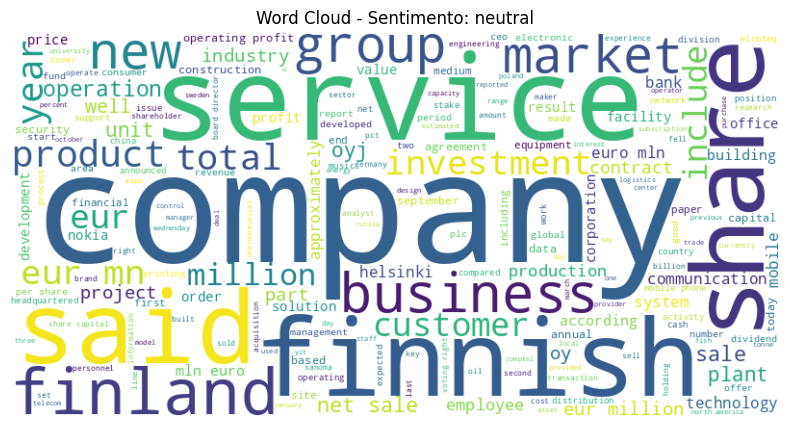

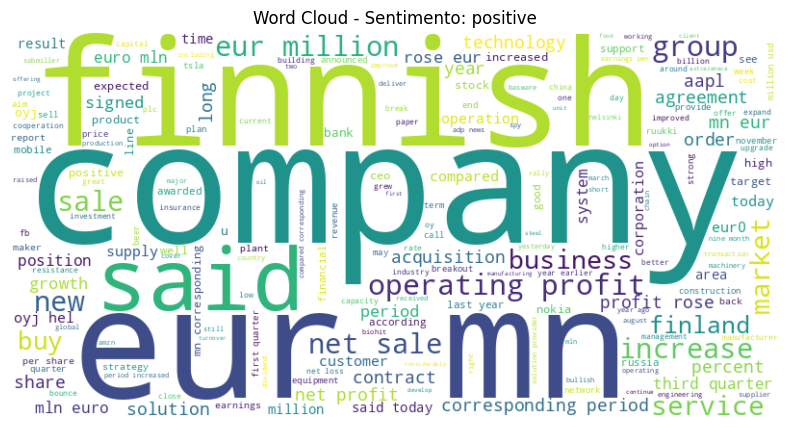

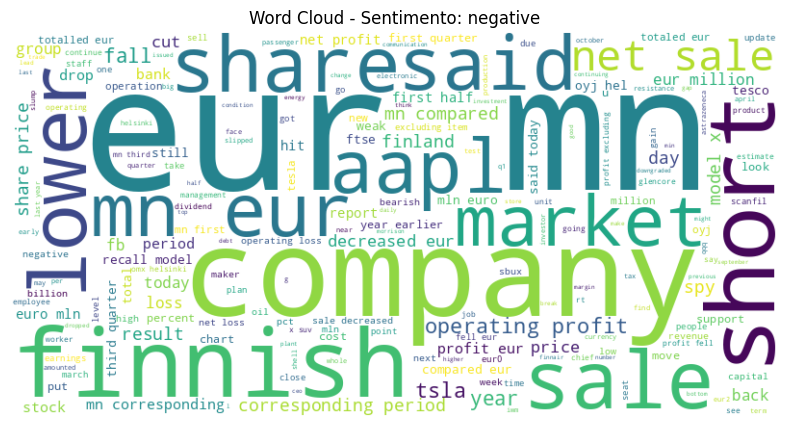

In [ ]:
#PLOTAGEM DE NUVENS DE PALAVRAS:

#JUNÇÃO DAS PALAVRAS TOKENIZADAS EM UMA ÚNICA STRING PARA CADA CLASSE:
texto_sentimento = {}
for sentimento in df_balanceado['Sentiment'].unique():
    tokenized_news = df_balanceado[df_balanceado['Sentiment'] == sentimento]['Sentence'].values
    texto_sentimento[sentimento] = ' '.join([' '.join(tokens) for tokens in tokenized_news])

#CRIAÇÃO E EXIBIÇÃO DA NUVEM DE PALAVRAS PARA CADA CLASSE DE SENTIMENTO:
for sentimento, texto in texto_sentimento.items():
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud - Sentimento: {sentimento}')
    plt.axis('off')
    plt.show()

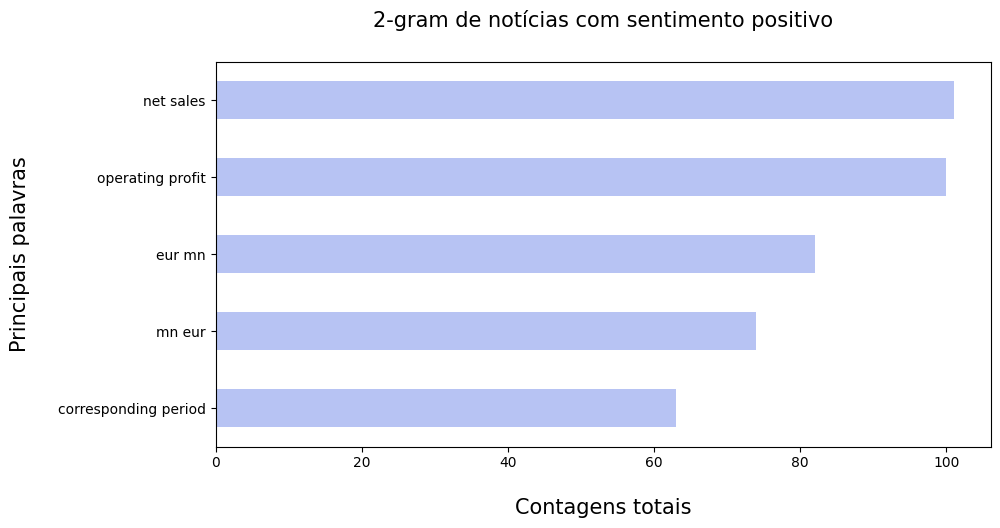

In [28]:
#PLOTAGEM DE GRÁFICOS N-GRAM PARA CADA CLASSE DE SENTIMENTO:

#ARMAZENAMENTO DAS STOPWORDS PARA PLOTAGEM DO N-GRAM:
stopwords = list(set(nltk.corpus.stopwords.words("english")))
df2 = pd.DataFrame({'Sentence':noticia_sem_links, 'Sentiment':sentimento_nao_repetido})

def Gram_Analysis(Corpus, Gram, N):
  #INSTÂNCIA DO VETORIZADOR
  Vectorizer = CountVectorizer(stop_words = stopwords, ngram_range=(Gram,Gram))
  #MATRIZ DE N-GRAMS:
  ngrams = Vectorizer.fit_transform(Corpus)
  #FREQUÊNCIA DE N-GRAMS:
  Count = ngrams.sum(axis=0)
  #LISTA DE PALAVRAS:
  words = [(word, Count[0, idx]) for word, idx in Vectorizer.vocabulary_.items()]
  #ORDENAÇÃO DESCENDENTE COM CHAVE:
  words = sorted(words, key = lambda x:x[1], reverse = True)

  return words[:N]

#UNIGRAMS:
#2-GRAM PARA A CLASSE DE SENTIMENTOS "POSITIVO":
df_positive = df2[df2["Sentiment"] == "positive"].dropna()
words_p = Gram_Analysis(df_positive["Sentence"], 2, 5)
Bigram = pd.DataFrame(words_p, columns = ["Words", "Counts"])

#VISUALIZAÇÃO DOS DADOS:
color_p=['#B7C3F3']
Bigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = color_p, figsize = (10, 5))
plt.title("2-gram de notícias com sentimento positivo", loc = "center", fontsize = 15, pad = 25)
plt.xlabel("Contagens totais", fontsize = 15, labelpad = 20)
plt.xticks(rotation = 0)
plt.ylabel("Principais palavras", fontsize = 15, labelpad = 20)
plt.savefig('imagens/p_2gram.png', dpi=300)
plt.show()

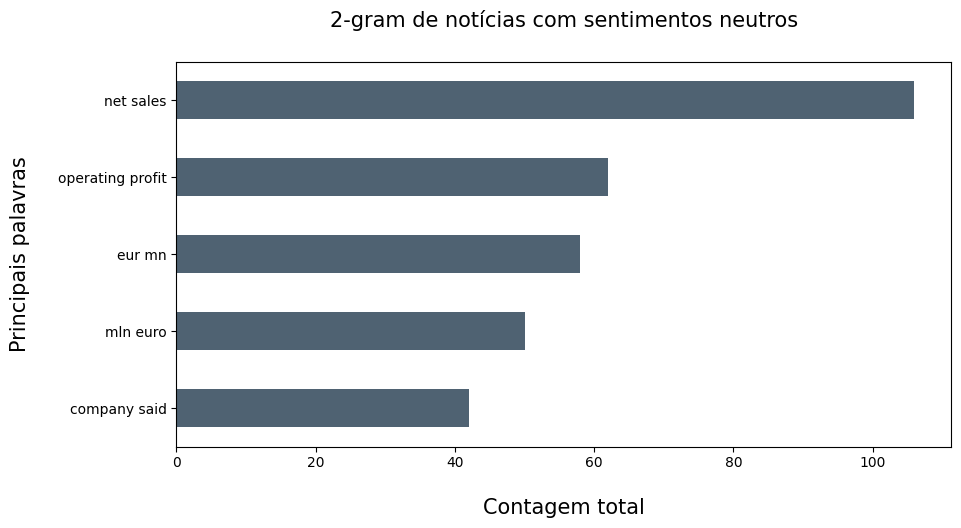

In [29]:
#2-GRAM PARA A CLASSE DE SENTIMENTOS "NEUTRO":
df_neutral = df2[df2["Sentiment"] == "neutral"].dropna()
words_nl = Gram_Analysis(df_neutral["Sentence"], 2, 5)
Bigram = pd.DataFrame(words_nl, columns = ["Words", "Counts"])

#VISUALIZAÇÃO DOS DADOS:
color_nl = ['#4F6272']
Bigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = color_nl, figsize = (10, 5))
plt.title("2-gram de notícias com sentimentos neutros", loc = "center", fontsize = 15, pad = 25)
plt.xlabel("Contagem total", fontsize = 15, labelpad = 20)
plt.xticks(rotation = 0)
plt.ylabel("Principais palavras", fontsize = 15, labelpad = 20)
plt.savefig('imagens/nl_2gram.png', dpi=300)
plt.show()

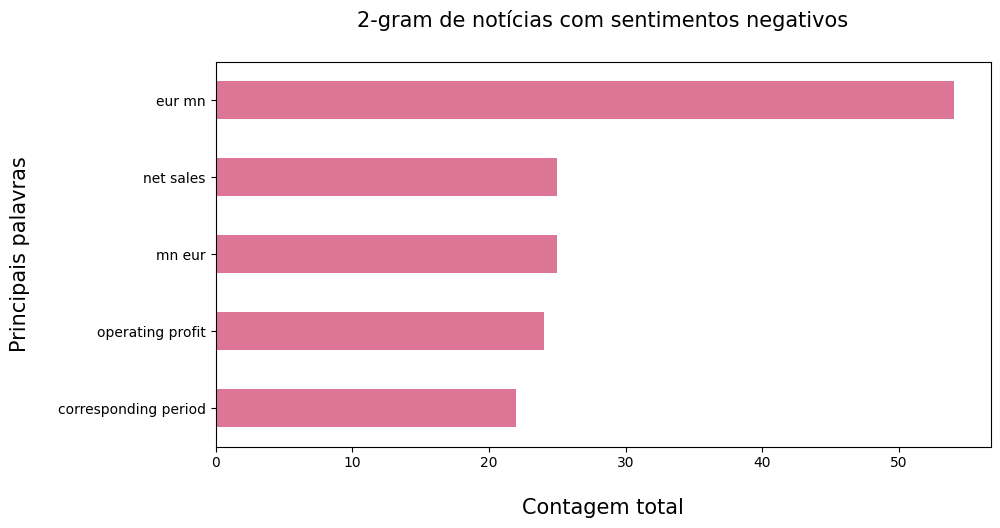

In [30]:
#2-GRAM PARA A CLASSE DE SENTIMENTOS "NEGATIVO":
df_negative = df2[df2["Sentiment"] == "negative"].dropna()
words_n = Gram_Analysis(df_negative["Sentence"], 2, 5)
Bigram = pd.DataFrame(words_n, columns = ["Words", "Counts"])

#VISUALIZAÇÃO DOS DADOS:
color_n = ['#DD7596']
Bigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = color_n, figsize = (10, 5))
plt.title("2-gram de notícias com sentimentos negativos", loc = "center", fontsize = 15, pad = 25)
plt.xlabel("Contagem total", fontsize = 15, labelpad = 20)
plt.xticks(rotation = 0)
plt.ylabel("Principais palavras", fontsize = 15, labelpad = 20)
plt.savefig('imagens/n_2gram.png', dpi=300)
plt.show()

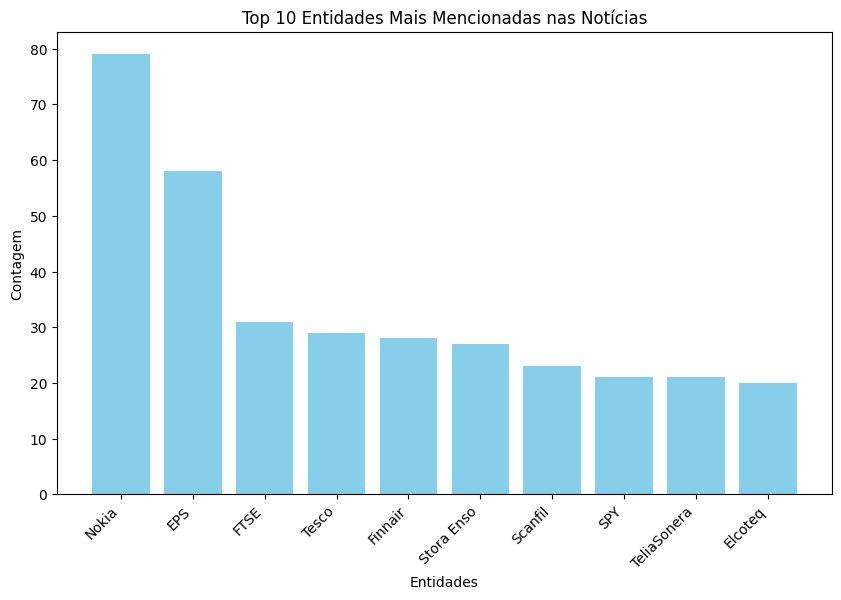

In [54]:
#LEVANTAMENTO DAS ENTIDADES RENOMADAS PRESENTES NO DATASET:

#CARREGANDO O MODELO DE IDIOMA EM PORTUGUÊS:
nlp = spacy.load("en_core_web_sm")

#FUNÇÃO PARA EXTRAIR ENTIDADES DOS TEXTOS::
def extrair_entidades(noticia):
    texto = ''.join(noticia)
    doc = nlp(texto)
    entidades = [entidade.text for entidade in doc.ents if entidade.label_ in ['ORG', 'PERSON'] and entidade.text not in ['EUR', 'EUR2', 'Group', 'Company']]
    return entidades

#APLICAÇÃO DA FUNÇÃO AOS TEXTOS DA COLUNA 'SENTENCE':
dataset['Referenced Organization'] = dataset['Sentence'].apply(extrair_entidades)

#FLATTEN DA LISTA DE ENTIDADES:
todas_entidades = [entidade for sublist in dataset['Referenced Organization'].tolist() for entidade in sublist]

#CONTAGEM DE ENTIDADES:
contagem_entidades = Counter(todas_entidades)

#TOP 10 ENTIDADES MAIS MENCIONADAS:
top_entidades = contagem_entidades.most_common(10)

#VISUALIZAÇÃO DA CONTAGEM DE ENTIDADES:
plt.figure(figsize=(10, 6))
plt.bar(*zip(*top_entidades), color='skyblue')
plt.xlabel('Entidades')
plt.ylabel('Contagem')
plt.title('Top 10 Entidades Mais Mencionadas nas Notícias')
plt.xticks(rotation=45, ha='right')
plt.show()

In [32]:
#PERSONALIZAÇÃO DO DATASET PARA PLOTAGEM DOS HISTOGRAMAS:

#FUNÇÃO PARA EXTRAIR OS 3 PRIMEIROS TOKENS DE UMA LISTA DE TOKENS:
def extrair_tres_primeiros(tokens):
    return ' '.join(tokens[:3])

#CRIAÇÃO DE UMA NOVA COLUNA "FIRST 3 WORDS" COM OS 3 PRIMEIROS TOKENS DA NOTÍCIA:
df_balanceado['First 3 words'] = df_balanceado['Sentence'].apply(extrair_tres_primeiros)

#FUNÇÃO PARA CONTAR O NÚMERO DE TOKENS:
def contar_palavras(tokens):
    return len(tokens)

#CRIAÇÃO DE UMA NOVA COLUNA "NUMBER OF WORDS" COM O NÚMERO DE PALAVRAS DE CADA NOTÍCIA:
df_balanceado['Number of words'] = df_balanceado['Sentence'].apply(contar_palavras)

#VISUALIZAÇÃO DO DATASET PERSONALIZADO:
df_balanceado

,Sentence,Sentiment,First 3 words,Number of words
866,"[customer, include, company, energy, process, ...",neutral,customer include company,8
2643,"[investment, worth, approximately, eur, 100mn]",neutral,investment worth approximately,5
4371,"[honkarakenne, also, decided, yesterday, sell,...",neutral,honkarakenne also decided,12
2920,"[company, said, offshore, segment, represented...",neutral,company said offshore,24
2016,"[vaisala, present, weather, detector, measure,...",neutral,vaisala present weather,12
...,...,...,...,...
5296,"[fb, hitting, everything, twtr]",negative,fb hitting everything,4
5298,"[bobe, premarket]",negative,bobe premarket,2
5303,"[acad, 2, today]",negative,acad 2 today,3
5313,"[sbux, pm, db, downgrade, pt, cut, 70, 64]",negative,sbux pm db,8


In [47]:
# PLOTAGEM DO HISTOGRAMA E DO GRÁFICO DE FREQUÊNCIA:

#AMOSTRA DE 5% DOS DADOS DO DATASET:
df_sample = df_balanceado.sample(frac=0.05, random_state=42)
pts = alt.selection(type="interval", encodings=["x"])

barras_de_linha = alt.Chart(df_sample).mark_bar().encode(
    x='Number of words:Q',
    y=alt.Y('First 3 words:O', sort=alt.EncodingSortField(field="Number of words", order='descending')),
    color='Sentiment:O',
    tooltip=['First 3 words', 'Number of words', 'Sentence']
).transform_filter(
    pts
).properties(
    height=700,
    width=300,
    title='Quantidade de palavras por notícia (amostra)'
)

hist = alt.Chart(df_sample).mark_bar().encode(
    x=alt.X('hbin:N', title='Quantidade de palavras'),
    y=alt.Y('count()', title='Contagem'),
    tooltip=[alt.Tooltip('count():Q', title='Contagem de notícias'),
             alt.Tooltip('mbin:N', title='Quantidade de palavras')],
    color=alt.condition(pts, alt.value("steelblue"), alt.value("lightgray"))
).properties(
    height=320,
    width=320,
    title='Histograma da quantidade de palavras por notícia (amostra)'
).add_selection(pts)

hconcat = alt.hconcat(
    barras_de_linha,
    hist,
    data=df_sample
).transform_bin(
    "hbin",
    field="Number of words",
    bin=alt.Bin(maxbins=50)
)

hconcat.save('1_tamanho_noticias_amostra.html')
hconcat

alt.HConcatChart(...)

In [51]:
#PERSONALIZAÇÃO DO DATASET PARA PLOTAGEM DO GRÁFICO DE DISTRIBUIÇÃO DE FREQUÊNCIA:
noticias = df_balanceado['Sentence']
noticias_texto = noticias.apply(lambda tokens: ' '.join(tokens))

#CRIAÇÃO DA MATRIZ DE TERMOS UTILIZANDO O COUNTVECTORIZER:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(noticias_texto)

#CRIAÇÃO DE UM NOVO DATAFRAME COM A DISTRIBUIÇÃO DE FREQUÊNCIA:
freq_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

#ATRIBUIÇÃO DA COLUNA "FIRST 3 WORDS" AO NOVO DATAFRAME:
freq_df['First 3 words'] = df_balanceado['First 3 words']

#CRIAÇÃO DE UM NOVO DATAFRAME PARA A DISTRIBUIÇÃO DE FREQUÊNCIA FINAL:
final_freq_df = pd.DataFrame()

#ITERAÇÃO SOBRE AS COLUNAS DE TERMOS NO DATAFRAME DE FREQUÊNCIA:
for termo in freq_df.columns:
    if termo != 'First 3 words':  # Ignora a coluna 'titulo'
        # Obtém a soma da frequência do termo em todas as notícia
        freq_total = freq_df[termo].sum()
        # Filtra as notícias onde o termo aparece
        noticias_com_termo = df_balanceado[df_balanceado.apply(lambda row: termo in row['Sentence'], axis=1)]['Sentence'].tolist()
        # Cria uma nova linha para o DataFrame final
        nova_linha = pd.DataFrame({'Term': [termo], 'Frequence': [freq_total], 'Sentence': [noticias_com_termo]})
        # Adiciona a nova linha ao DataFrame final
        final_freq_df = pd.concat([final_freq_df, nova_linha], ignore_index=True)

#SALVAMENTO DO NOVO DATAFRAME EM CSV:
final_freq_df.to_csv('distribuicao_frequencia_final.csv', index=False)

#VISUALIZAÇÃO DO NOVO DATAFRAME:
final_freq_df = final_freq_df.sort_values(by='Frequence',ascending=False)
final_freq_df.head()

,Term,Frequence,Sentence
1608,eur,332,"[[investment, worth, approximately, eur, 100mn..."
1032,company,238,"[[customer, include, company, energy, process,..."
2947,mn,206,"[[company, withdrawing, second, part, eur, mn,..."
3510,profit,174,"[[third, quarter, fiscal, 2008, efore, swung, ..."
3892,sale,169,"[[group, net, sale, eur, 235, million, 2009, e..."


In [53]:
#PLOTAGEM DO GRÁFICO DE DISTRIBUIÇÃO DE FREQUÊNCIA:
df_freq50 = final_freq_df[0:50]

wordfreq = alt.Chart(df_freq50).mark_bar().encode(
    y='Frequence:Q',
    x= alt.X('Term:O', sort = alt.EncodingSortField(field="Frequence", order='descending')),
    color = alt.value('steelblue'),
    tooltip=[
        'Term:O',
        'Frequence:Q',
        alt.Tooltip('Sentence:O', title='Noticias onde o termo ocorre')
    ]
).properties(
    height=300,
    width = 850,
    title = '50 termos mais frequentes'
)

wordfreq.save('2_frequencia_termos.html')
wordfreq

alt.Chart(...)